In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy
from pathlib import Path
import os 
import pandas as pd
import seaborn as sns
import cv2

Text(0.5, 0.98, 'semantic - blood_cells - 80 - 0_00 - ensemble - PU - 2')

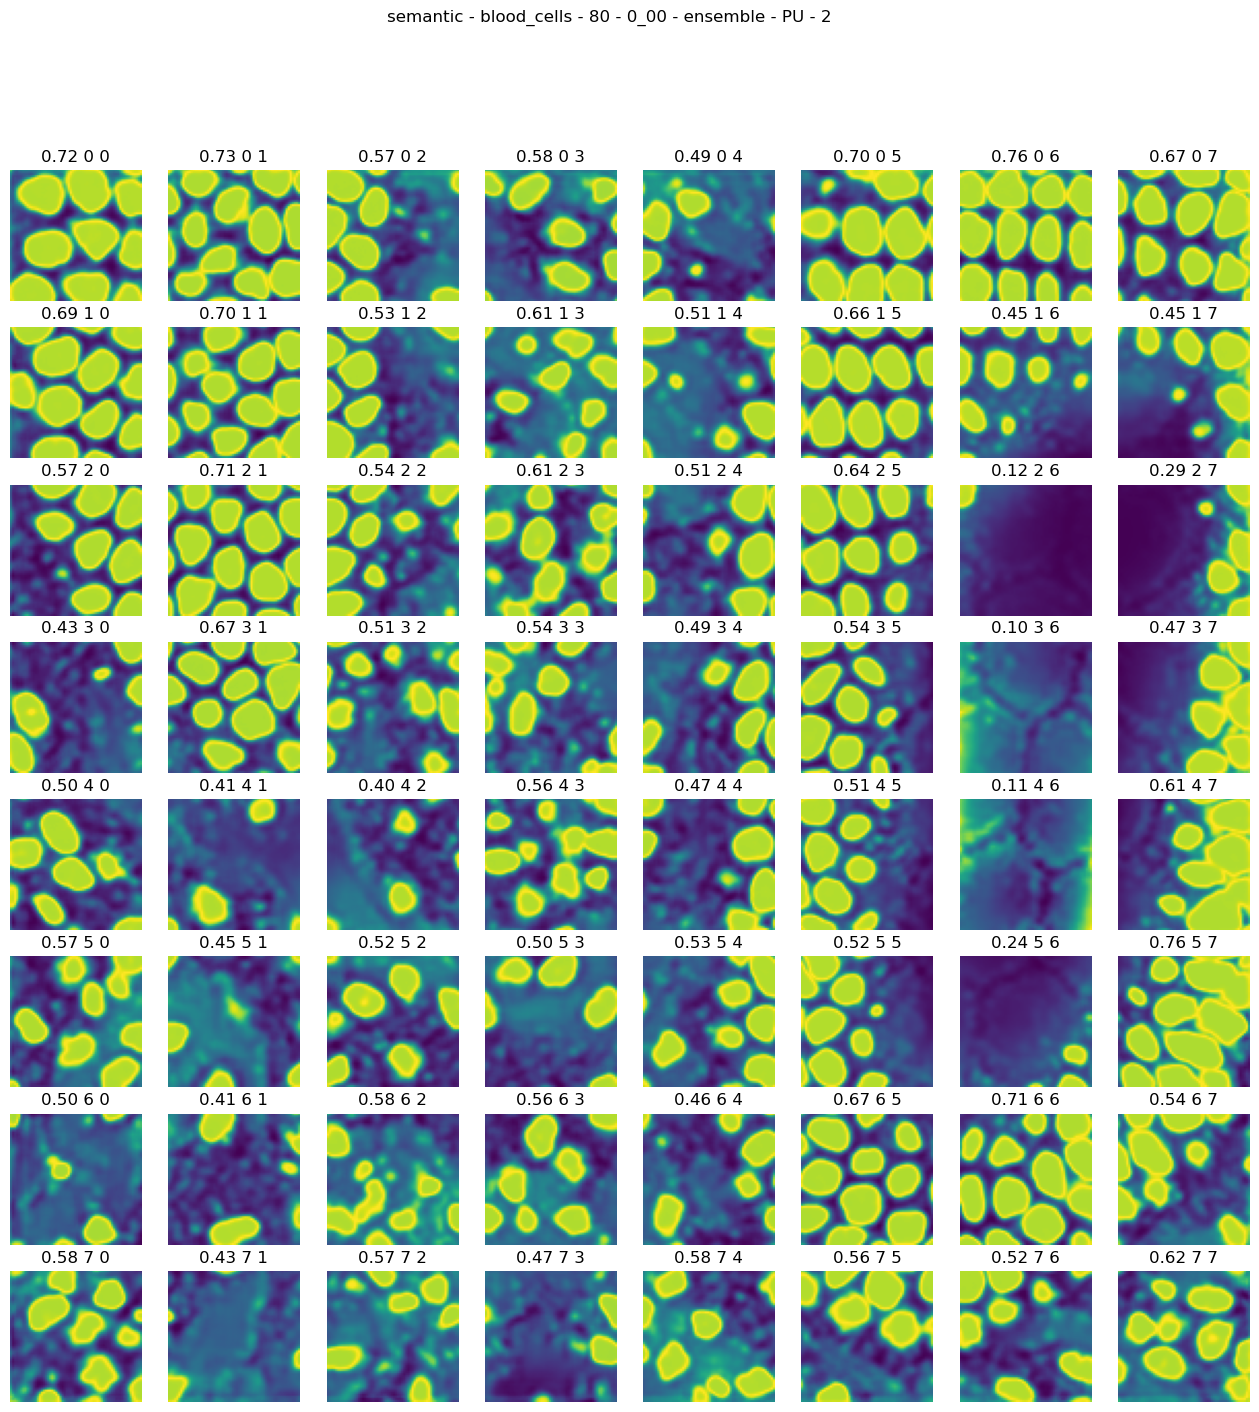

In [2]:
uq_path = Path("C:/Users/cwinklm/Documents/Data/uncertainty_arctique_v1-0-corrected_14/UQ_maps")

IDX = 2

plt.figure(figsize=(16, 16))

# sample 1 
task = "semantic"
model_noise = 80
variation =  "blood_cells"  #"nuclei_intensity"
data_noise = "0_00"
uq_method = "ensemble"
decomp = "PU"
map_type = f"{task}_noise_{model_noise}_{variation}_{data_noise}_{uq_method}_{decomp}.npy"
uq_maps = np.load(uq_path.joinpath(map_type))


for i in range(8): 
    for j in range(8):
        uq_map = uq_maps[IDX]/np.log(6)
        plt.subplot(8,8,i*8+j+1)
        uq_patch = uq_map[i*64:(i+1)*64, j*64:(j+1)*64]
        plt.imshow(uq_patch)
        plt.title(f"{np.mean(uq_patch):.2f} {i} {j}")
        plt.axis("off")
plt.suptitle(f"{task} - {variation} - {model_noise} - {data_noise} - {uq_method} - {decomp} - {IDX}")  


In [3]:
# i = 6
# j=1
# patch = uq_map[i*64:(i+1)*64, j*64:(j+1)*64]
# np.save(f"{task}_noise_{model_noise}_{variation}_{data_noise}_{uq_method}_{decomp}_{IDX}_{6}_{1}.png", patch)

In [4]:

def rook_weights(grid_shape):
    """
    Generate a rook neighborhood weight matrix for a given grid size.
    
    Parameters:
    grid_shape : tuple (rows, cols) representing the grid dimensions.
    
    Returns:
    2D numpy array representing the adjacency weight matrix.
    """
    rows, cols = grid_shape
    n = rows * cols
    weights = np.zeros((n, n))
    
    for r in range(rows):
        for c in range(cols):
            index = r * cols + c
            # Right neighbor
            if c < cols - 1:
                right_index = r * cols + (c + 1)
                weights[index, right_index] = 1
                weights[right_index, index] = 1  # Symmetric
            # Bottom neighbor
            if r < rows - 1:
                bottom_index = (r + 1) * cols + c
                weights[index, bottom_index] = 1
                weights[bottom_index, index] = 1  # Symmetric
    
    return weights

def gearys_c(values, grid_shape=None, weights=None):
    """
    Compute Geary's C spatial autocorrelation.
    
    Parameters:
    values     : 1D array of observed values (length = grid_size[0] * grid_size[1]).
    grid_shape : Tuple (rows, cols) to generate a rook neighborhood weight matrix if weights is None.
    weights    : 2D numpy array of spatial weights (optional, defaults to rook neighborhood if None).
    
    Returns:
    Geary's C statistic.
    """
    n = len(values)
    
    if weights is None:
        if grid_shape is None:
            raise ValueError("Either grid_shape or weights must be provided.")
        weights = rook_weights(grid_shape)
    
    mean_val = np.mean(values)
    
    # Compute numerator: sum of squared differences between neighbors
    numerator = 0
    for i in range(n):
        for j in range(n):
            numerator += weights[i, j] * (values[i] - values[j]) ** 2
            
    # Compute denominator: sum of squared deviations from mean
    denominator = 2 * np.sum((values - mean_val) ** 2)
    
    # Sum of all weights
    W = np.sum(weights)
    
    return (n - 1) / (2 * W) * (numerator / denominator)

# Example usage with a 3x3 grid and default rook neighborhood
values = np.array([10, 20, 15, 25, 30, 12, 18, 22, 28])  # Example values
grid_shape = (3, 3)  # Grid size for rook neighborhood

gearys_c_value = gearys_c(values, grid_shape=grid_shape)
print("Geary's C:", gearys_c_value)


Geary's C: 0.5306563039723662


In [5]:
def edge_density_score(image):
    """
    Compute an edge density score based on the proportion of edge pixels.
    
    Parameters:
        image (2D numpy array): Grayscale image.
        
    Returns:
        score (float): Ratio of edge pixels to total pixels.
    """

    if np.max(image) <= 1:
        image = (image * 255).astype(np.uint8)

    # Apply Canny edge detection
    edges = cv2.Canny(image, 100, 200)  # Adjust thresholds as needed

    # Compute edge density: fraction of pixels that are edges
    score = np.sum(edges > 0) / edges.size
    
    return score


def edge_energy_score(image):
    """
    Compute an edge energy score based on gradient magnitude.
    
    Parameters:
        image (2D numpy array): Grayscale image.
        
    Returns:
        score (float): Mean gradient magnitude.
    """
    if np.max(image) <= 1:
        image = (image * 255).astype(np.uint8)

    # Compute Sobel gradients
    sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    
    # Compute gradient magnitude
    gradient_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)

    # Compute mean gradient magnitude as a score
    score = np.mean(gradient_magnitude)
    
    return score


def shannon_entropy(image, base=2):
    """Computes the Shannon entropy of a 2D array (grayscale image).
    
    Args:
        image (np.ndarray): 2D numpy array representing the image.
        base (int): Base of the logarithm (default=2 for bits).
    
    Returns:
        float: Shannon entropy value.
    """
    # Flatten the image to 1D
    pixels = image.flatten()

    # Compute histogram (probability distribution)
    hist, _ = np.histogram(pixels, bins=256, range=(0, 255), density=True)

    # Compute Shannon entropy
    return entropy(hist, base=base)

# Example usage:
image = np.random.randint(0, 256, (100, 100), dtype=np.uint8)  # Random 100x100 grayscale image
entropy_value = shannon_entropy(image)
print(f"Shannon Entropy: {entropy_value:.4f}")


Shannon Entropy: 7.9796


In [6]:
def calc_measure_string(uq_map): 
    mean = np.mean(uq_map)
    eds = edge_density_score(uq_map)
    H = shannon_entropy(uq_map)
    gearys = gearys_c(uq_map.flatten(), grid_shape=(uq_map.shape[0], uq_map.shape[1]))
    return f"GA: {mean:.2f}, EDS: {eds:.2f}, H: {H:.2f}, GC: {gearys:.2f}", mean, eds, H, gearys

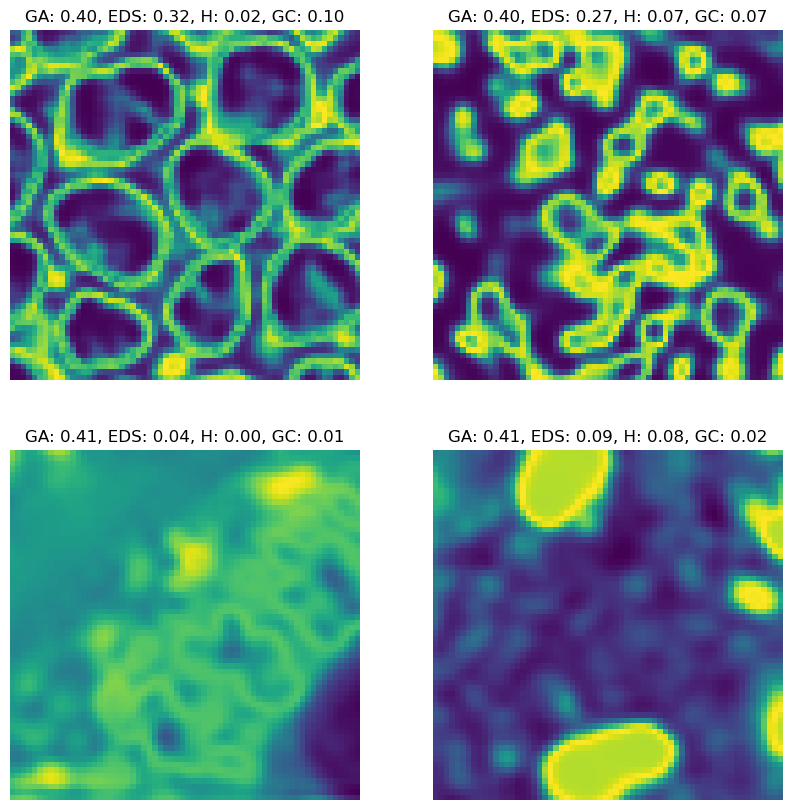

In [7]:
sample_folder = Path("C:/Users/cwinklm/Documents/AggroUQ/qualitative_spatial_samples")
samples = [s for s in os.listdir(sample_folder) if s.endswith(".npy")]

res = {"Sample_ID": [], "GA": [], "EDS": [], "H": [], "GC": [], "string": []}


plt.figure(figsize=(10,10))
for sample_idx, sample in enumerate(samples):
    uq_map = np.load(sample_folder.joinpath(sample))
    measure_string, mean, eds, H, gearys = calc_measure_string(uq_map)
    res["Sample_ID"].append(sample)
    res["GA"].append(mean)  
    res["EDS"].append(eds)
    res["H"].append(H)
    res["GC"].append(gearys)
    res["string"].append(measure_string)
    plt.subplot(2,2,sample_idx+1)
    plt.imshow(uq_map)
    plt.axis("off")
    plt.title(measure_string)
#plt.show()

plt.savefig(f"{sample_folder}/spatial_example.png", dpi=150)

df = pd.DataFrame(res)  
df.to_csv(f"{sample_folder}/measures.csv", index=False)